In [1]:
import numpy as np
import iisignature
import matplotlib.pyplot as plt
import copy

In [2]:
def generate_ou_process(n_samples, n_steps, mu=0, theta=0.15, sigma=0.3, anomaly=0):
    dt = 1.0
    timeline = np.zeros((n_steps))
    X = np.zeros((n_samples, n_steps))
    X[:, 0] = mu  # начальные условия
    for t in range(1, n_steps):
        dX = theta * (mu - X[:, t-1]) * dt + sigma * np.random.normal(size=n_samples) * np.sqrt(dt)
        X[:, t] = X[:, t-1] + dX
        timeline[t] = dt + timeline[t-1]
    if anomaly:
        for sample in range(0, n_samples) :
            anomaly_time = np.random.randint(0, n_steps)
            X[sample, anomaly_time] += np.random.choice([1, -1]) * anomaly # аномалия +- 5 сигм

    return X, timeline

In [3]:
def generate_sin_func(n_samples, n_periods, n_steps_in_period = 100, anomaly = False) :
    n_steps = n_periods * n_steps_in_period
    range_ = n_periods * 2 * np.pi    # range - длина генерации синуса
    dt = range_ / (n_steps)    # шаг по оси Ox
    timeline = np.zeros((n_steps))

    X = np.zeros((n_samples, n_steps))
    params = np.zeros((n_samples, 3))
    for i in range(0, n_samples):
        params[i][0] = np.random.rand()     # множитель синуса
        params[i][1] = 1      # множитель аргумента синуса. Стоит 1 чтобы период всегда был 2 пи
        params[i][2] = np.random.uniform(0, np.pi)  # сдвиг фазы

    for t in range(0, n_steps):
        X[:, t] = params[:, 0] * np.sin(dt * t * params[:, 1] + params[:, 2])
        timeline[t] = dt * t
    if (anomaly) :
        for sample in range(0, n_samples) :
            anomaly_time = np.random.randint(0, n_steps)
            X[sample, anomaly_time] = np.random.choice([1, -1]) * params[sample, 0]  # аномалия равная макс/мин знач. синуса

    return X, timeline


In [4]:
def generate_linear_func(n_samples, n_steps, range_ = 1.0, stationary_window = 5, anomaly = False) :
    dt = range_ / n_steps
    timeline = np.zeros((n_steps))
    X = np.zeros((n_samples, n_steps))
    params = np.zeros((n_samples))
    for i in range(0, n_samples):
        params[i] = np.random.rand()  # коэффициент наклона
    cur_decr = 0
    for t in range(0, n_steps):
        X[:, t] = params[:] * t
        if (t % stationary_window == 0) :      # stationary window - как период у синуса, для стационаризации
            cur_decr = copy.deepcopy((X[:, t]))
        X[:, t] -= cur_decr
        timeline[t] = t
    if (anomaly) :
        for sample in range(0, n_samples) :
            anomaly_time = np.random.randint(0, n_steps)
            X[sample, anomaly_time] += stationary_window * params[sample]  # аномалия + максимальное значение в "периоде"
    return X, timeline

Ornstein–Uhlenbeck Process

In [5]:
n_samples = 4
n_steps = 100
mu = 0.0
theta = 0.15
sigma = 0.3 
level = 2

In [6]:
# Ornstein–Uhlenbeck process without anomaly
X_noanomaly, timeline = generate_ou_process(4, 100, mu, theta, sigma, anomaly=0)

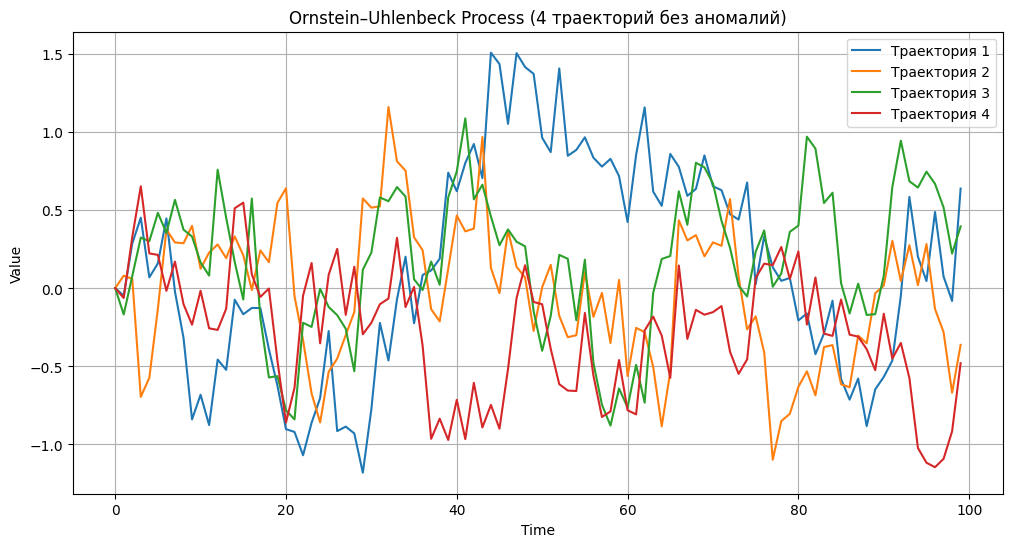

In [7]:
plt.figure(figsize=(12, 6))
for i in range(n_samples):
    plt.plot(timeline, X_noanomaly[i, :], label=f"Траектория {i+1}")
plt.title("Ornstein–Uhlenbeck Process ({} траекторий без аномалий)".format(n_samples))
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
signatures_no_anomaly = []
for i in range(n_samples):
    signature = iisignature.sig(np.column_stack((timeline, X_noanomaly[i])), level)
    signatures_no_anomaly.append(signature)
signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)

In [9]:
iisignature.siglength(2, 2)

6

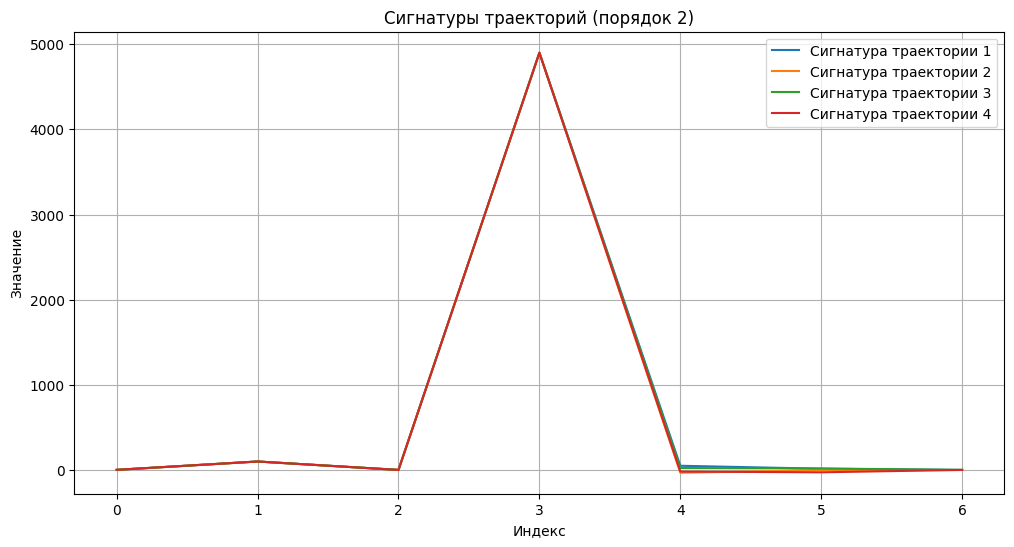

In [10]:
plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures_no_anomaly):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Сигнатуры траекторий (порядок {})".format(level))
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

Нормируем время

In [11]:
def normalize_arr(arr):
    arr = np.array(arr, dtype=float)
    mean = np.mean(arr)
    std_dev = np.std(arr)

    return (arr - mean) / std_dev

In [12]:
signatures_no_anomaly_normalized_time = []
for i in range(n_samples):
    signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_noanomaly[i])), level)
    signatures_no_anomaly_normalized_time.append(signature)
signatures_no_anomaly_normalized_time = np.insert(signatures_no_anomaly_normalized_time, 0, 1, axis=1)

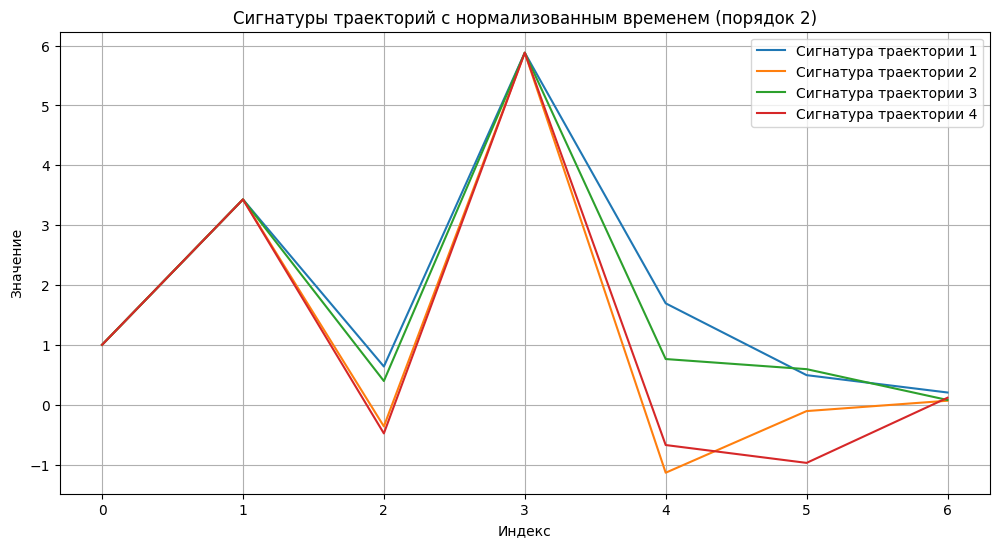

In [13]:
plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures_no_anomaly_normalized_time):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Сигнатуры траекторий c нормализованным временем (порядок {})".format(level))
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

Нормирование времени снижает влияние на элементы сигнатуры, особенно на элементы, которые являются интегральными траекториями, созданными по первой координате траектории (времени), такие как S(X)^(1,1) S(X)^(1,1,1) и так далее 

Нормируем случайные величины процесса

In [14]:
signatures_no_anomaly_normalized_time_and_process = []
for i in range(n_samples):
    signature = iisignature.sig(np.column_stack((normalize_arr(timeline), normalize_arr(X_noanomaly[i]))), level)
    signatures_no_anomaly_normalized_time_and_process.append(signature)
signatures_no_anomaly_normalized_time_and_process = np.insert(signatures_no_anomaly_normalized_time_and_process, 0, 1, axis=1)

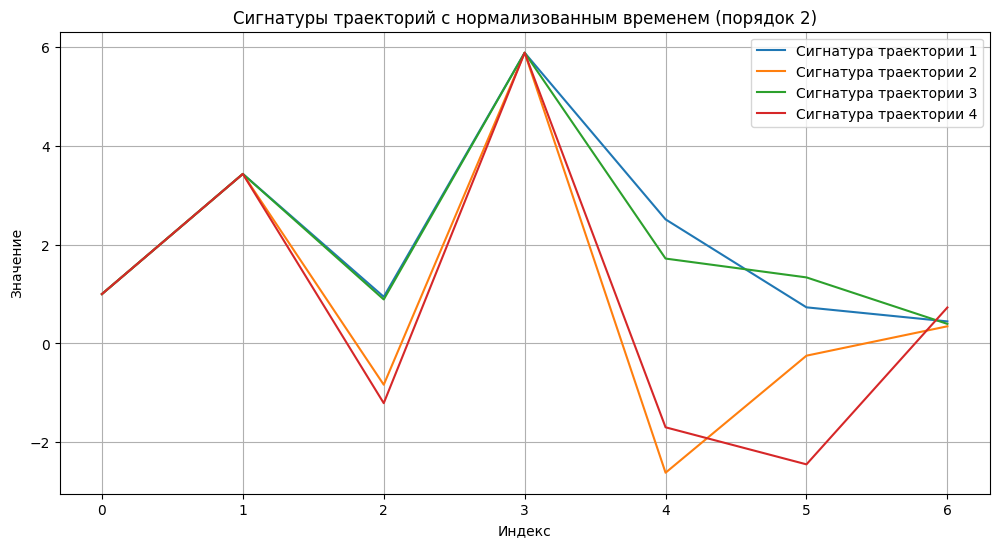

In [15]:
plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures_no_anomaly_normalized_time_and_process):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Сигнатуры траекторий c нормализованным временем (порядок {})".format(level))
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

Изменений в масштабе нет, поэтому пока смысла нормировать все последовательности в траектории X = (X_time, X_ou) не вижу

Добавим аномалии в созданные процессы

In [16]:
def add_anomaly_to_random_vector(vectors, anomaly):
    random_index = np.random.randint(0, vectors.shape[0])
    vectors[random_index] += anomaly
    return vectors

In [19]:
# Ornstein–Uhlenbeck process with anomaly
X_anomaly = X_noanomaly.copy()
for i in range(n_samples):
    X_anomaly[i, :] = add_anomaly_to_random_vector(X_anomaly[i, :], np.random.choice([1, -1]) * 5)

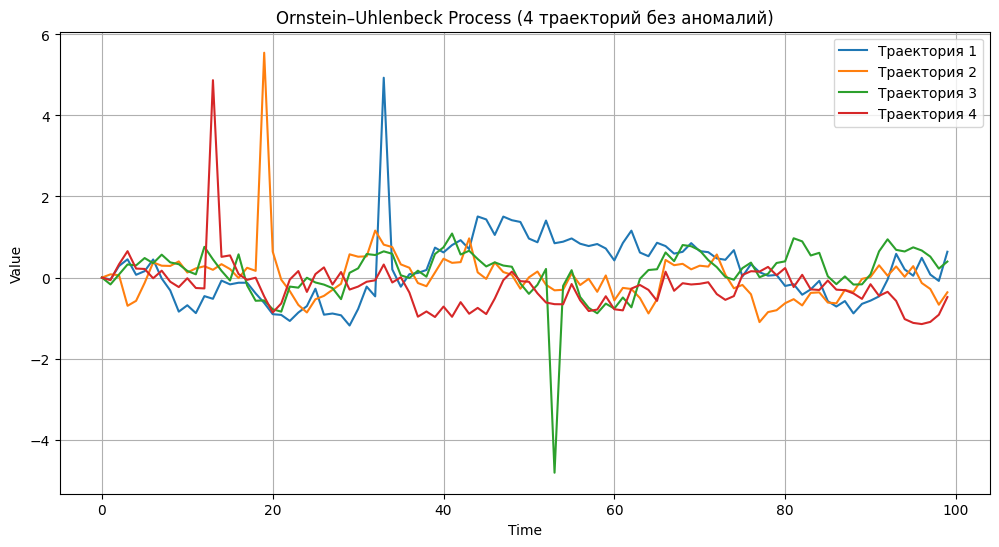

In [20]:
plt.figure(figsize=(12, 6))
for i in range(n_samples):
    plt.plot(timeline, X_anomaly[i, :], label=f"Траектория {i+1}")
plt.title("Ornstein–Uhlenbeck Process ({} траекторий без аномалий)".format(n_samples))
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
signatures_with_anomaly = []
for i in range(n_samples):
    signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_anomaly[i])), level)
    signatures_with_anomaly.append(signature)
signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)

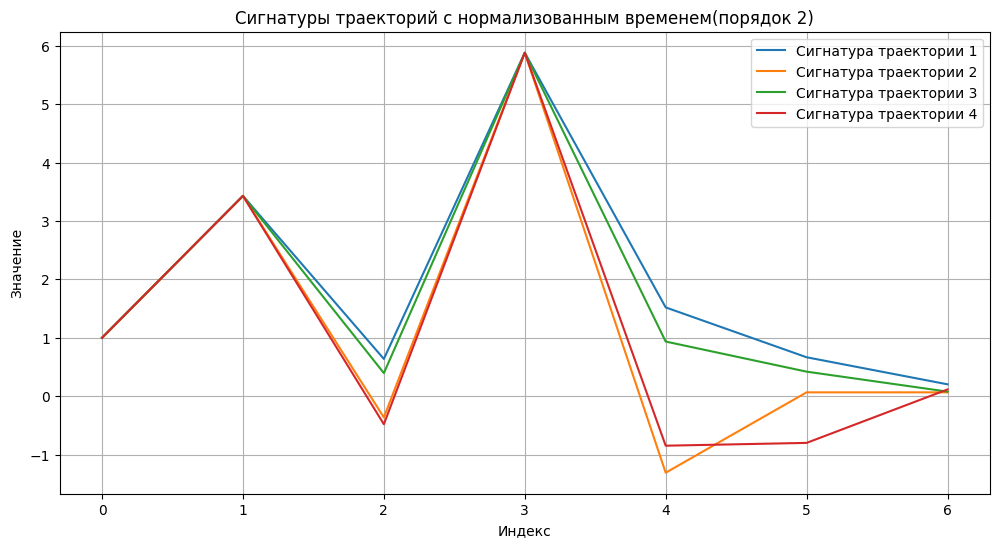

In [22]:
plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures_with_anomaly):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Сигнатуры траекторий c нормализованным временем(порядок {})".format(level))
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
signatures_no_anomaly = signatures_no_anomaly_normalized_time

In [24]:
diff_signatures = [signatures_no_anomaly[i] - signatures_with_anomaly[i] for i in range(len(signatures_with_anomaly))]
diff_signatures

[array([ 0.00000000e+00,  0.00000000e+00, -4.44089210e-16,  0.00000000e+00,
         1.73213742e-01, -1.73213742e-01, -1.05471187e-15]),
 array([ 0.00000000e+00,  0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
         1.73213742e-01, -1.73213742e-01, -7.77156117e-16]),
 array([ 0.00000000e+00,  0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
        -1.73213742e-01,  1.73213742e-01,  1.38777878e-15]),
 array([ 0.00000000e+00,  0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
         1.73213742e-01, -1.73213742e-01,  2.10942375e-15])]

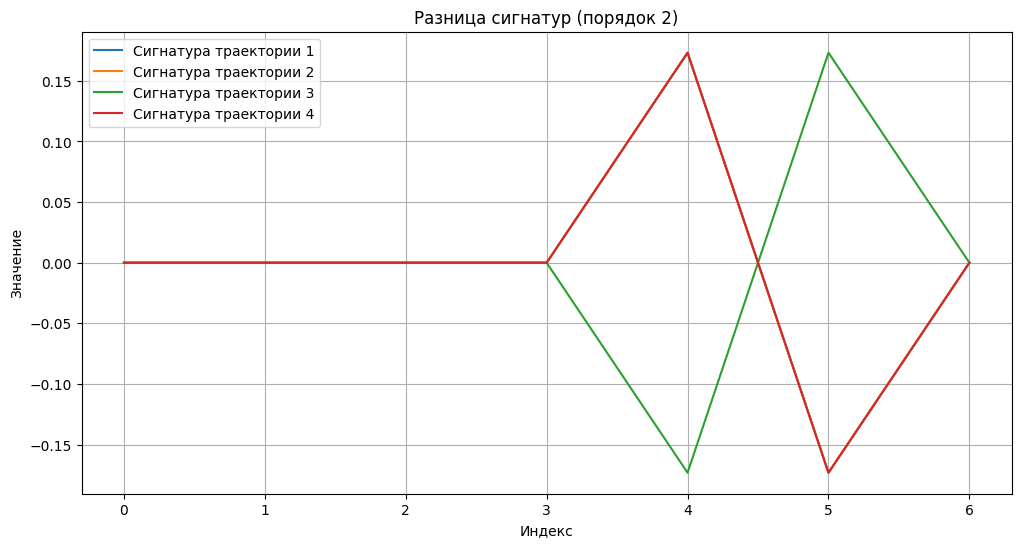

In [25]:
plt.figure(figsize=(12, 6))
for i, signature in enumerate(diff_signatures):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Разница сигнатур (порядок {})".format(level))
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

Без нормализации времени

In [26]:
signatures_no_anomaly = []
for i in range(n_samples):
    signature = iisignature.sig(np.column_stack((timeline, X_noanomaly[i])), level)
    signatures_no_anomaly.append(signature)
signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)

In [27]:
signatures_with_anomaly = []
for i in range(n_samples):
    signature = iisignature.sig(np.column_stack((timeline, X_anomaly[i])), level)
    signatures_with_anomaly.append(signature)
signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)

In [28]:
diff_signatures = [signatures_no_anomaly[i] - signatures_with_anomaly[i] for i in range(len(signatures_with_anomaly))]
diff_signatures

[array([ 0.00000000e+00,  0.00000000e+00, -4.44089210e-16,  0.00000000e+00,
         5.00000000e+00, -5.00000000e+00, -1.05471187e-15]),
 array([ 0.00000000e+00,  0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
         5.00000000e+00, -5.00000000e+00, -7.77156117e-16]),
 array([ 0.00000000e+00,  0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
        -5.00000000e+00,  5.00000000e+00,  1.38777878e-15]),
 array([ 0.00000000e+00,  0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
         5.00000000e+00, -5.00000000e+00,  2.10942375e-15])]

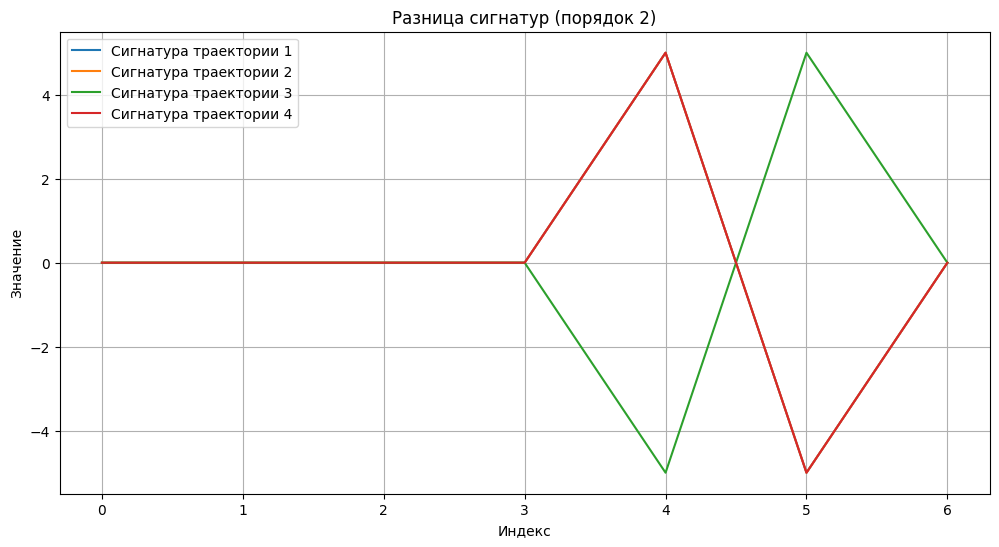

In [29]:
plt.figure(figsize=(12, 6))
for i, signature in enumerate(diff_signatures):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Разница сигнатур (порядок {})".format(level))
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

Не видно влияния нормирования компоненты времени

Базовая модель обнаружения аномалий

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [31]:
np.random.seed(42)
torch.manual_seed(42)

In [32]:
def train_nn(model_params, X, y):
    n_samples = model_params["n_samples"]
    n_steps = model_params["n_steps"]
    num_epochs = model_params["num_epochs"]
    lr = model_params["lr"]
    batch_size = model_params["batch_size"]
    test_size = model_params["test_size"]
    hidden_size = model_params["hidden_size"]
    mu = model_params["mu"]
    theta = model_params["theta"]
    sigma = model_params["sigma"]
    anomaly_level = model_params["anomaly_level"]
    dimension = model_params["dimension"]
    level = model_params["level"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    class ThreeLayerNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(ThreeLayerNN, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, output_size)
            self.relu = nn.ReLU()
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.sigmoid(self.fc3(x))
            return x

    input_size = X.shape[1]
    hidden_size = hidden_size
    output_size = 1
    model = ThreeLayerNN(input_size, hidden_size, output_size)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_accuracy = 0
    best_epoch = 0
    loss_best_accuracy = 10**10
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Тестирование модели
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                predicted = (outputs > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

            accuracy = 100 * correct / total
            if loss_best_accuracy > loss:
                best_accuracy = accuracy
                best_epoch = epoch
                loss_best_accuracy = loss

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

    print(f"Лучшая точность: {best_accuracy:.2f}% на эпохе {best_epoch+1}")
    return best_accuracy


Без использования сигнатур

In [69]:
model_params = {
    "n_samples": 1000,
    "n_steps": 1000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

Размер процесса: 100
Epoch [1/20], Loss: 0.5347, Accuracy: 70.00%
Epoch [2/20], Loss: 0.6830, Accuracy: 74.00%
Epoch [3/20], Loss: 0.3283, Accuracy: 74.50%
Epoch [4/20], Loss: 0.2354, Accuracy: 81.00%
Epoch [5/20], Loss: 0.0703, Accuracy: 87.50%
Epoch [6/20], Loss: 0.0394, Accuracy: 85.50%
Epoch [7/20], Loss: 0.0443, Accuracy: 88.00%
Epoch [8/20], Loss: 0.0093, Accuracy: 87.00%
Epoch [9/20], Loss: 0.0038, Accuracy: 88.00%
Epoch [10/20], Loss: 0.0021, Accuracy: 88.00%
Epoch [11/20], Loss: 0.0015, Accuracy: 88.00%
Epoch [12/20], Loss: 0.0011, Accuracy: 87.00%
Epoch [13/20], Loss: 0.0015, Accuracy: 88.00%
Epoch [14/20], Loss: 0.0007, Accuracy: 88.00%
Epoch [15/20], Loss: 0.0008, Accuracy: 88.00%
Epoch [16/20], Loss: 0.0008, Accuracy: 87.50%
Epoch [17/20], Loss: 0.0005, Accuracy: 87.50%
Epoch [18/20], Loss: 0.0002, Accuracy: 87.50%
Epoch [19/20], Loss: 0.0003, Accuracy: 87.50%
Epoch [20/20], Loss: 0.0002, Accuracy: 87.50%
Лучшая точность: 87.50% на эпохе 20
Размер процесса: 500
Epoch [1/20

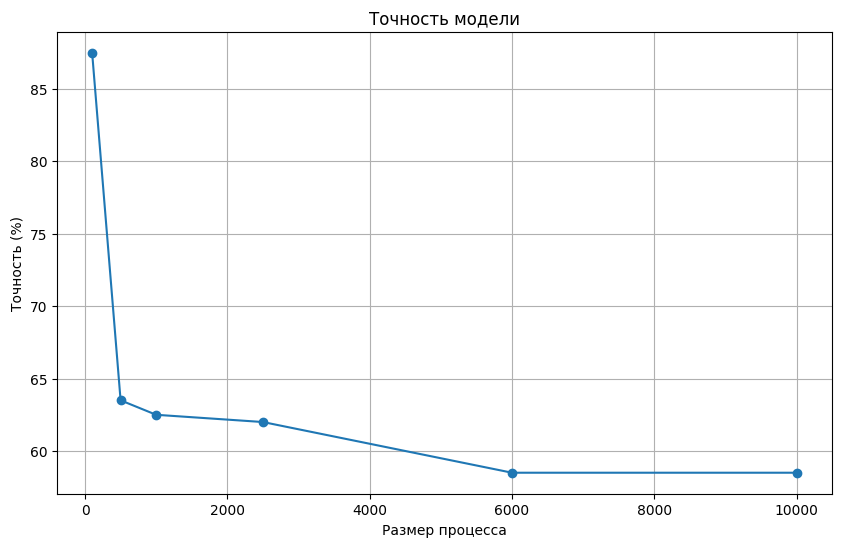

In [70]:
n_steps_arr = [100, 500, 1000, 2500, 6000, 10000]
accuracies = []

for n_steps in n_steps_arr:
    model_params["n_steps"] = n_steps
    X_noanomaly, _ = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    X_anomaly, _ = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    y_noanomaly = np.zeros(X_noanomaly.shape[0])
    y_anomaly = np.ones(X_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))
    
    print(f"Размер процесса: {model_params['n_steps']}")
    accuracy = train_nn(model_params, X, y)
    accuracies.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_steps_arr, accuracies, marker='o')
plt.title("Точность модели")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

Увеличим размер выборки

In [71]:
model_params = {
    "n_samples": 10000,
    "n_steps": 1000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

Размер процесса: 100
Epoch [1/20], Loss: 0.0548, Accuracy: 97.25%
Epoch [2/20], Loss: 0.0081, Accuracy: 99.05%
Epoch [3/20], Loss: 0.1473, Accuracy: 99.10%
Epoch [4/20], Loss: 0.0011, Accuracy: 99.45%
Epoch [5/20], Loss: 0.0012, Accuracy: 99.15%
Epoch [6/20], Loss: 0.0019, Accuracy: 98.20%
Epoch [7/20], Loss: 0.0018, Accuracy: 99.45%
Epoch [8/20], Loss: 0.0075, Accuracy: 99.00%
Epoch [9/20], Loss: 0.0055, Accuracy: 98.80%
Epoch [10/20], Loss: 0.0003, Accuracy: 99.70%
Epoch [11/20], Loss: 0.0001, Accuracy: 99.90%
Epoch [12/20], Loss: 0.0001, Accuracy: 99.90%
Epoch [13/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [14/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [15/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [16/20], Loss: 0.0001, Accuracy: 99.85%
Epoch [17/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [18/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [19/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [20/20], Loss: 0.0001, Accuracy: 99.85%
Лучшая точность: 99.85% на эпохе 18
Размер процесса: 500
Epoch [1/20

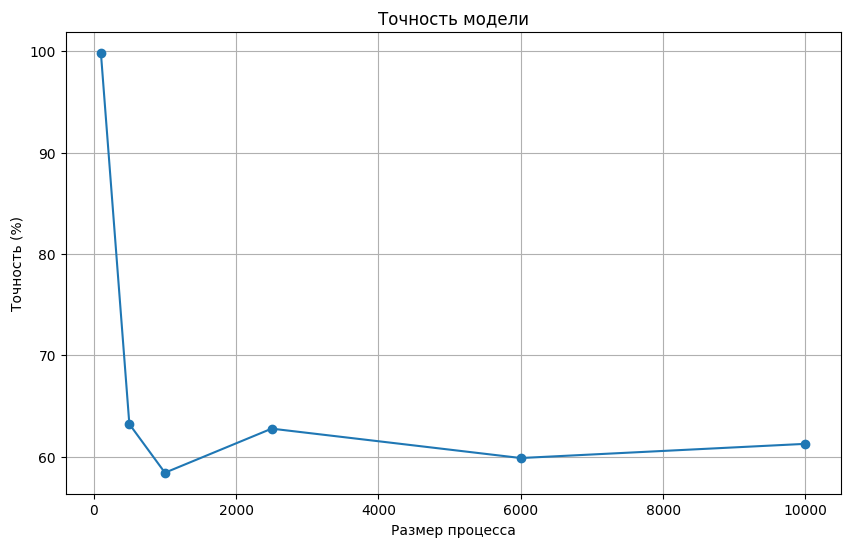

In [72]:
n_steps_arr = [100, 500, 1000, 2500, 6000, 10000]
accuracies = []

for n_steps in n_steps_arr:
    model_params["n_steps"] = n_steps
    X_noanomaly, _ = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    X_anomaly, _ = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    y_noanomaly = np.zeros(X_noanomaly.shape[0])
    y_anomaly = np.ones(X_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))
    
    print(f"Размер процесса: {model_params['n_steps']}")
    accuracy = train_nn(model_params, X, y)
    accuracies.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_steps_arr, accuracies, marker='o')
plt.title("Точность модели")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

С сигнатурами/ сигнатура считается по всей траектории , без нормализации времени

In [73]:
model_params = {
    "n_samples": 10000,
    "n_steps": 1000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

Размер процесса: 100
Epoch [1/20], Loss: 0.0476, Accuracy: 98.10%
Epoch [2/20], Loss: 0.0620, Accuracy: 98.35%
Epoch [3/20], Loss: 0.1830, Accuracy: 98.25%
Epoch [4/20], Loss: 0.2154, Accuracy: 99.65%
Epoch [5/20], Loss: 0.0023, Accuracy: 99.65%
Epoch [6/20], Loss: 0.0007, Accuracy: 99.60%
Epoch [7/20], Loss: 0.0002, Accuracy: 99.95%
Epoch [8/20], Loss: 0.0002, Accuracy: 99.85%
Epoch [9/20], Loss: 0.0001, Accuracy: 99.85%
Epoch [10/20], Loss: 0.0002, Accuracy: 99.85%
Epoch [11/20], Loss: 0.0001, Accuracy: 99.85%
Epoch [12/20], Loss: 0.0001, Accuracy: 99.85%
Epoch [13/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [14/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [15/20], Loss: 0.0001, Accuracy: 99.85%
Epoch [16/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [17/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [18/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [19/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [20/20], Loss: 0.0000, Accuracy: 99.90%
Лучшая точность: 99.90% на эпохе 20
Размер процесса: 500
Epoch [1/20

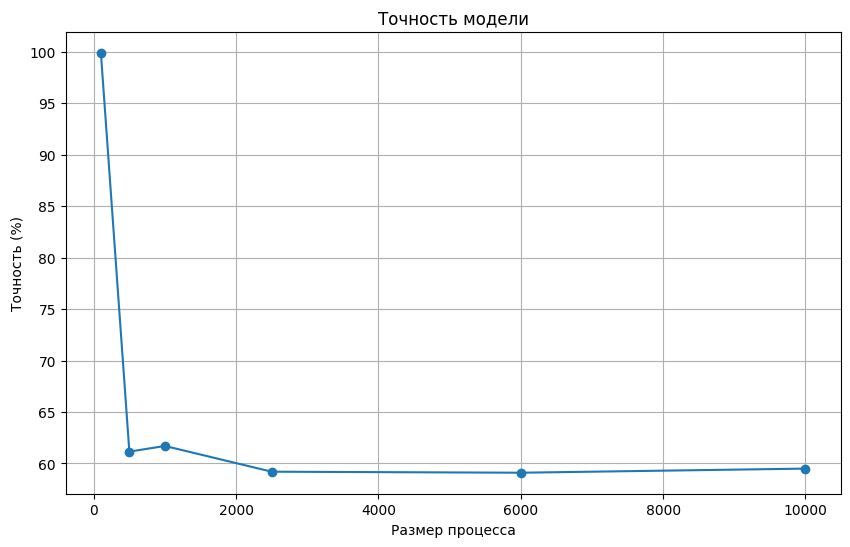

In [74]:
n_steps_arr = [100, 500, 1000, 2500, 6000, 10000]
accuracies = []

for n_steps in n_steps_arr:
    model_params["n_steps"] = n_steps
    X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    
    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((timeline, X_noanomaly[i])), level)
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)
    
    X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((timeline, X_anomaly[i])), level)
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)
    
    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))
    
    print(f"Размер процесса: {model_params['n_steps']}")
    accuracy = train_nn(model_params, X, y)
    accuracies.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_steps_arr, accuracies, marker='o')
plt.title("Точность модели")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

С нормализацией временной компоненты


In [75]:
model_params = {
    "n_samples": 10000,
    "n_steps": 1000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

Размер процесса: 100
Epoch [1/20], Loss: 0.0150, Accuracy: 98.30%
Epoch [2/20], Loss: 0.0072, Accuracy: 98.40%
Epoch [3/20], Loss: 0.0025, Accuracy: 99.70%
Epoch [4/20], Loss: 0.0010, Accuracy: 99.75%
Epoch [5/20], Loss: 0.0005, Accuracy: 99.85%
Epoch [6/20], Loss: 0.0001, Accuracy: 99.80%
Epoch [7/20], Loss: 0.0002, Accuracy: 99.80%
Epoch [8/20], Loss: 0.0001, Accuracy: 99.80%
Epoch [9/20], Loss: 0.0000, Accuracy: 99.80%
Epoch [10/20], Loss: 0.0000, Accuracy: 99.80%
Epoch [11/20], Loss: 0.0000, Accuracy: 99.80%
Epoch [12/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [13/20], Loss: 0.0000, Accuracy: 99.85%
Epoch [14/20], Loss: 0.0001, Accuracy: 99.90%
Epoch [15/20], Loss: 0.0000, Accuracy: 99.90%
Epoch [16/20], Loss: 0.0000, Accuracy: 99.90%
Epoch [17/20], Loss: 0.0000, Accuracy: 99.90%
Epoch [18/20], Loss: 0.0000, Accuracy: 99.90%
Epoch [19/20], Loss: 0.0000, Accuracy: 99.90%
Epoch [20/20], Loss: 0.0000, Accuracy: 99.90%
Лучшая точность: 99.90% на эпохе 19
Размер процесса: 500
Epoch [1/20

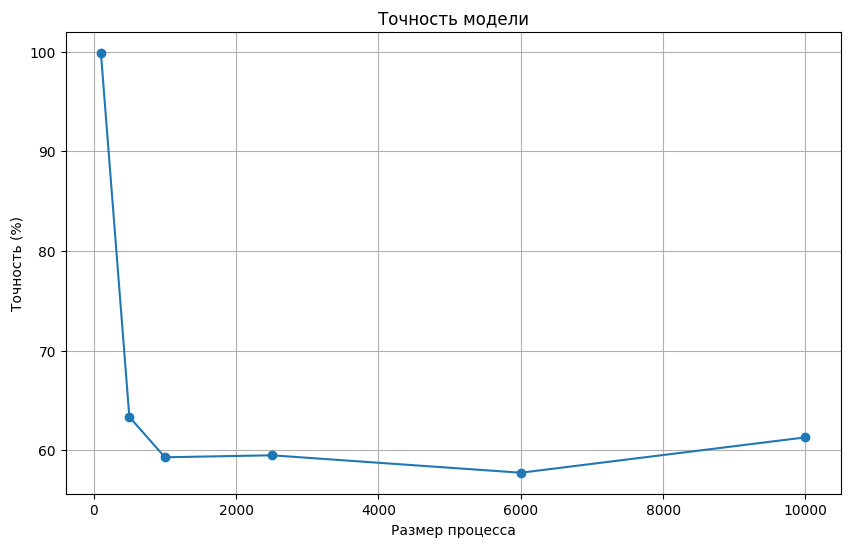

In [76]:
n_steps_arr = [100, 500, 1000, 2500, 6000, 10000]
accuracies = []

for n_steps in n_steps_arr:
    model_params["n_steps"] = n_steps
    X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    
    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_noanomaly[i])), level)
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)
    
    X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_anomaly[i])), level)
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)
    
    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))
    
    print(f"Размер процесса: {model_params['n_steps']}")
    accuracy = train_nn(model_params, X, y)
    accuracies.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_steps_arr, accuracies, marker='o')
plt.title("Точность модели")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

Заметим, что сигнатура, вычисляемая по всему размеру траектории процесса, не обладает способностью различать процесс с аномалией и без
Также заметим, что с ростом размера траектории процесса способность различать процесс с аномалией и без пропадает и у модели, обучаемой на данных, не обработанных сигнатурой.
Также нормализация времени значительно улучшает способность модели

Пробуем вычислять сигнатуры на окнах те разбиваем траекторию процесса на равные отрезки считаем на каждом сигнатуру и усредняем
Предполагаем, что такой метод поможет сигнатуре быть более чувствительной к аномалии

In [77]:
def calc_sig_window(window, path, timeline):
    # assert(len(path) % window == 0)
    mean_sig = np.zeros(iisignature.siglength(dimension, level)) 
    for i in range(int(len(path)/window)):
        last_border = (i+1)*window
        if last_border > len(path):
            last_border = len(path)
        mean_sig += iisignature.sig(np.column_stack((timeline[i*window:(i+1)*window], path[i*window:(i+1)*window ])), level)
    mean_sig /= int(len(path)/window)
    return mean_sig

In [78]:
model_params = {
    "n_samples": 10000,
    "n_steps": 500,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

In [79]:
window = 50

In [80]:
X_noanomaly, timeline = generate_ou_process(int(1), n_steps, mu, theta, sigma, anomaly=0)
print(X_noanomaly.shape)

(1, 500)


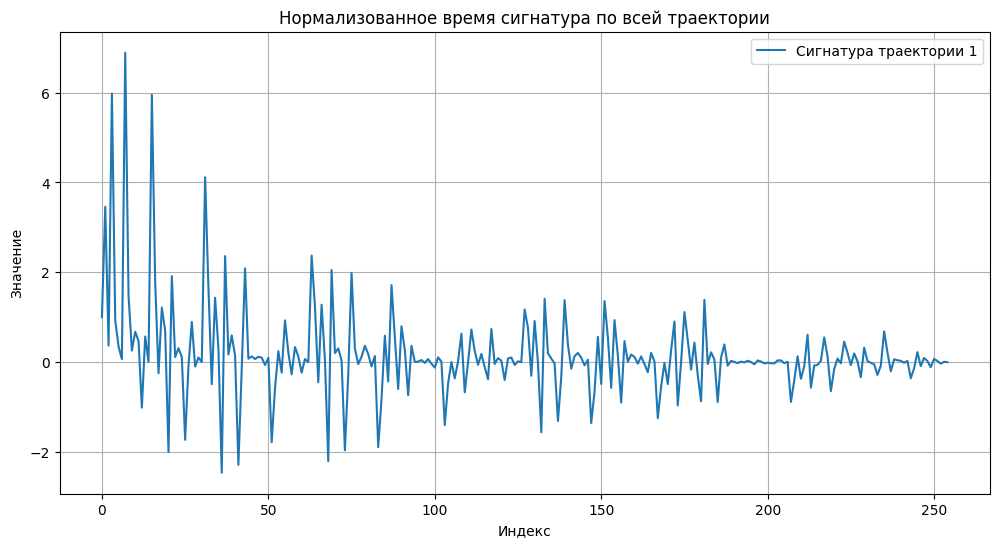

In [81]:
signatures = []
signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_noanomaly[0])), level)
signatures.append(signature)
signatures = np.insert(signatures, 0, 1, axis=1)

plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Нормализованное время сигнатура по всей траектории")
# plt.ylim(-25*10**3,175*10**3)
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

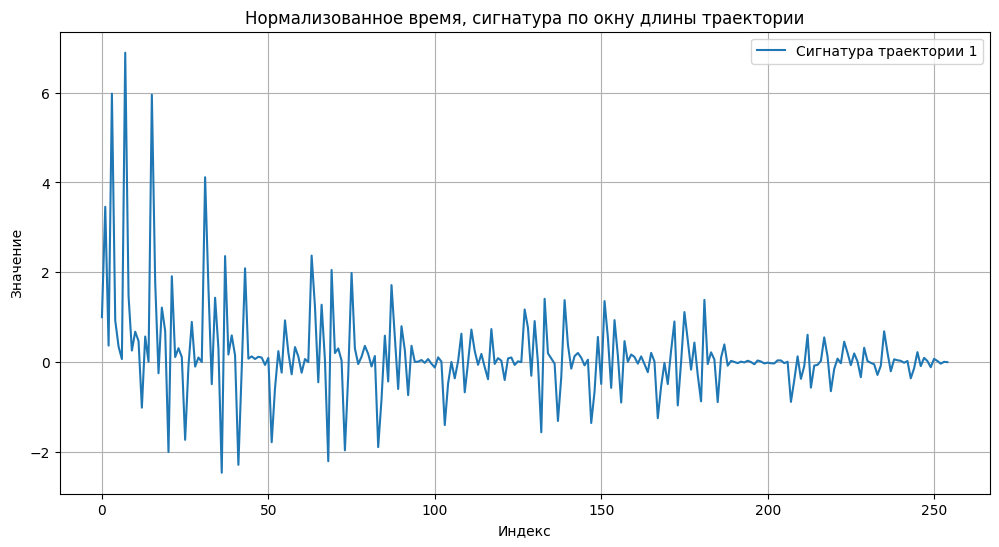

In [82]:
signatures = []
# signature = iisignature.sig(np.column_stack((timeline, X_noanomaly[0])), level)
# signatures.append(signature)
signature = calc_sig_window(n_steps, X_noanomaly[0], normalize_arr(timeline))
signatures.append(signature)
signatures = np.insert(signatures, 0, 1, axis=1)

plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Нормализованное время, сигнатура по окну длины траектории")
# plt.ylim(-25*10**3,175*10**3)
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

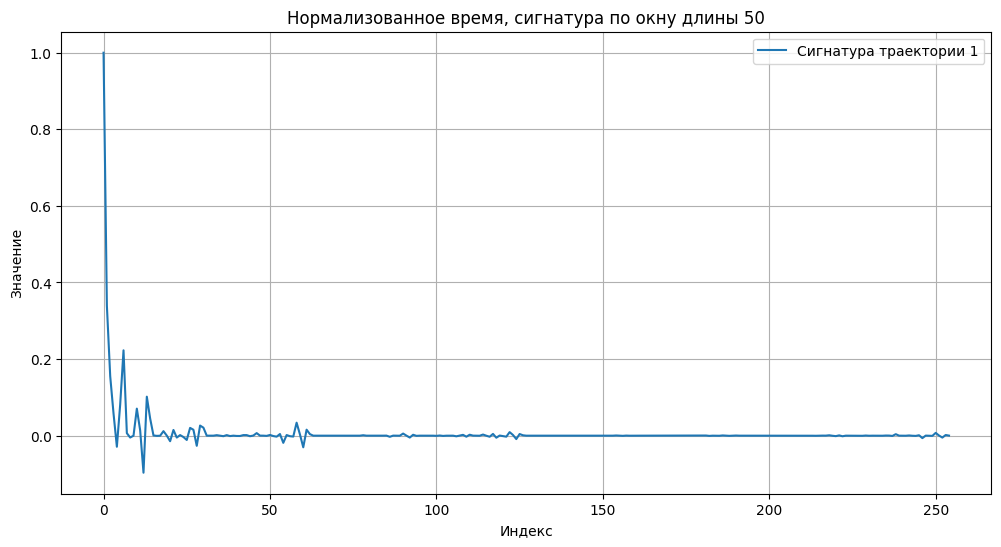

In [83]:
signatures = []
# signature = iisignature.sig(np.column_stack((timeline, X_noanomaly[0])), level)
# signatures.append(signature)
signature = calc_sig_window(window, X_noanomaly[0], normalize_arr(timeline))
signatures.append(signature)
signatures = np.insert(signatures, 0, 1, axis=1)

plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title(f"Нормализованное время, сигнатура по окну длины {window}")
# plt.ylim(-25*10**3,175*10**3)
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

Рассмотрим различные окна

In [173]:
model_params = {
    "n_samples": 10000,
    "n_steps": 1000,
    "num_epochs": 25,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

Окно не используется тк данные без сигнатур

Окно: 2
Epoch [1/25], Loss: 0.6544, Accuracy: 70.00%
Epoch [2/25], Loss: 0.5118, Accuracy: 69.95%
Epoch [3/25], Loss: 0.6247, Accuracy: 69.00%
Epoch [4/25], Loss: 0.3370, Accuracy: 65.80%
Epoch [5/25], Loss: 0.5380, Accuracy: 64.10%
Epoch [6/25], Loss: 0.3399, Accuracy: 60.10%
Epoch [7/25], Loss: 0.4029, Accuracy: 60.90%
Epoch [8/25], Loss: 0.1177, Accuracy: 61.30%
Epoch [9/25], Loss: 0.0211, Accuracy: 60.60%
Epoch [10/25], Loss: 0.0731, Accuracy: 59.35%
Epoch [11/25], Loss: 0.0067, Accuracy: 61.85%
Epoch [12/25], Loss: 0.0531, Accuracy: 58.55%
Epoch [13/25], Loss: 0.0681, Accuracy: 60.25%
Epoch [14/25], Loss: 0.1152, Accuracy: 59.25%
Epoch [15/25], Loss: 0.0029, Accuracy: 59.90%
Epoch [16/25], Loss: 0.2245, Accuracy: 59.85%
Epoch [17/25], Loss: 0.0046, Accuracy: 59.65%
Epoch [18/25], Loss: 0.0151, Accuracy: 62.10%
Epoch [19/25], Loss: 0.1603, Accuracy: 56.60%
Epoch [20/25], Loss: 0.0456, Accuracy: 59.45%
Epoch [21/25], Loss: 0.0408, Accuracy: 60.20%
Epoch [22/25], Loss: 0.0101, Accura

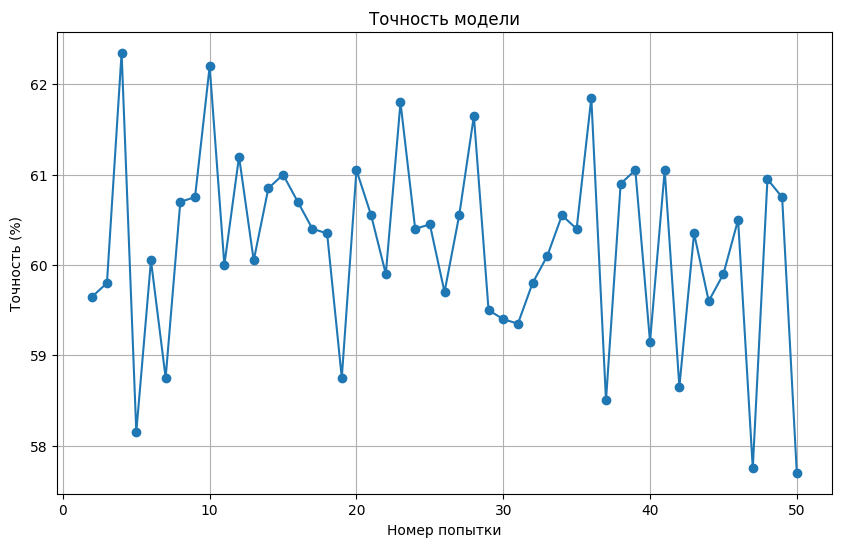

In [176]:
window_sizes = range(2, 51)
accuracies_no_anomaly = []

for window in window_sizes:
    X_noanomaly, _ = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    X_anomaly, _ = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    y_noanomaly = np.zeros(X_noanomaly.shape[0])
    y_anomaly = np.ones(X_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))
    
    print(f"Окно: {window}")
    accuracy = train_nn(model_params, X, y)
    accuracies_no_anomaly.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, accuracies_no_anomaly, marker='o')
plt.title("Точность модели")
plt.xlabel("Номер попытки")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

Рассмотрим сигнатуры по окнам

In [19]:
model_params = {
    "n_samples": 10000,
    "n_steps": 1000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

Окно: 2
Epoch [1/20], Loss: 0.0844, Accuracy: 95.65%
Epoch [2/20], Loss: 0.1439, Accuracy: 96.85%
Epoch [3/20], Loss: 0.0331, Accuracy: 93.40%
Epoch [4/20], Loss: 0.0247, Accuracy: 97.30%
Epoch [5/20], Loss: 0.0222, Accuracy: 97.05%
Epoch [6/20], Loss: 0.0187, Accuracy: 97.65%
Epoch [7/20], Loss: 0.0600, Accuracy: 97.60%
Epoch [8/20], Loss: 0.1433, Accuracy: 97.60%
Epoch [9/20], Loss: 0.0369, Accuracy: 97.05%
Epoch [10/20], Loss: 0.0264, Accuracy: 97.70%
Epoch [11/20], Loss: 0.0548, Accuracy: 97.85%
Epoch [12/20], Loss: 0.0361, Accuracy: 97.75%
Epoch [13/20], Loss: 0.0833, Accuracy: 97.85%
Epoch [14/20], Loss: 0.0136, Accuracy: 97.50%
Epoch [15/20], Loss: 0.0125, Accuracy: 98.10%
Epoch [16/20], Loss: 0.0087, Accuracy: 97.95%
Epoch [17/20], Loss: 0.0173, Accuracy: 97.20%
Epoch [18/20], Loss: 0.0464, Accuracy: 98.25%
Epoch [19/20], Loss: 0.0242, Accuracy: 97.80%
Epoch [20/20], Loss: 0.0072, Accuracy: 98.45%
Лучшая точность: 98.45% на эпохе 20
Окно: 6
Epoch [1/20], Loss: 0.0494, Accuracy:

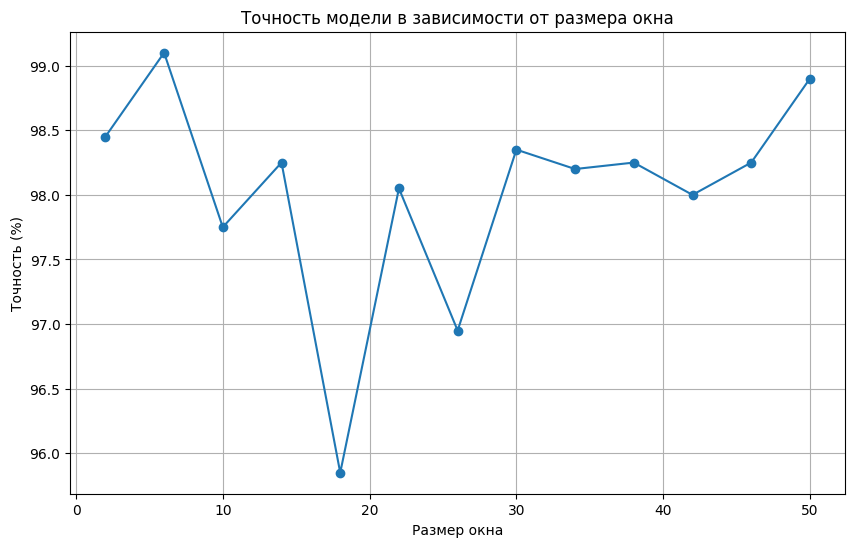

In [21]:
window_sizes = range(2, 51, 4)
accuracies = []

for window in window_sizes:
    X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    
    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_noanomaly[i])), level)
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)
    
    X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_anomaly[i])), level)
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)
    
    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    
    X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))

    print(f"Окно: {window}")
    accuracy = train_nn(model_params, X, y)
    accuracies.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, accuracies, marker='o')
plt.title("Точность модели в зависимости от размера окна")
plt.xlabel("Размер окна")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

In [23]:
X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)

signatures_no_anomaly = []
for i in range(X_noanomaly.shape[0]):
    signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_noanomaly[i])), level)
    signatures_no_anomaly.append(signature)
signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)

X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)

signatures_with_anomaly = []
for i in range(X_anomaly.shape[0]):
    signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_anomaly[i])), level)
    signatures_with_anomaly.append(signature)
signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)

y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
y_anomaly = np.ones(signatures_with_anomaly.shape[0])

X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
y = np.hstack((y_noanomaly, y_anomaly))

train_nn(model_params, X, y)

Epoch [1/20], Loss: 0.0334, Accuracy: 96.35%
Epoch [2/20], Loss: 0.1276, Accuracy: 97.30%
Epoch [3/20], Loss: 0.0293, Accuracy: 95.45%
Epoch [4/20], Loss: 0.0539, Accuracy: 97.60%
Epoch [5/20], Loss: 0.2824, Accuracy: 97.20%
Epoch [6/20], Loss: 0.0473, Accuracy: 97.70%
Epoch [7/20], Loss: 0.0065, Accuracy: 97.45%
Epoch [8/20], Loss: 0.0543, Accuracy: 98.10%
Epoch [9/20], Loss: 0.0013, Accuracy: 96.60%
Epoch [10/20], Loss: 0.0061, Accuracy: 98.15%
Epoch [11/20], Loss: 0.0034, Accuracy: 97.15%
Epoch [12/20], Loss: 0.0179, Accuracy: 97.50%
Epoch [13/20], Loss: 0.1269, Accuracy: 98.25%
Epoch [14/20], Loss: 0.0335, Accuracy: 98.10%
Epoch [15/20], Loss: 0.0375, Accuracy: 98.60%
Epoch [16/20], Loss: 0.0572, Accuracy: 98.85%
Epoch [17/20], Loss: 0.0182, Accuracy: 98.70%
Epoch [18/20], Loss: 0.0194, Accuracy: 98.60%
Epoch [19/20], Loss: 0.0686, Accuracy: 98.45%
Epoch [20/20], Loss: 0.1432, Accuracy: 98.00%
Лучшая точность: 96.60% на эпохе 9


96.6

Рассмотрим большие окна

Окно: 51
Epoch [1/20], Loss: 0.0531, Accuracy: 95.75%
Epoch [2/20], Loss: 0.3573, Accuracy: 97.70%
Epoch [3/20], Loss: 0.3380, Accuracy: 95.40%
Epoch [4/20], Loss: 0.1312, Accuracy: 95.70%
Epoch [5/20], Loss: 0.1584, Accuracy: 98.60%
Epoch [6/20], Loss: 0.0116, Accuracy: 98.65%
Epoch [7/20], Loss: 0.2156, Accuracy: 98.15%
Epoch [8/20], Loss: 0.0171, Accuracy: 98.70%
Epoch [9/20], Loss: 0.0397, Accuracy: 98.60%
Epoch [10/20], Loss: 0.0373, Accuracy: 98.20%
Epoch [11/20], Loss: 0.0641, Accuracy: 98.65%
Epoch [12/20], Loss: 0.0701, Accuracy: 98.00%
Epoch [13/20], Loss: 0.0469, Accuracy: 98.65%
Epoch [14/20], Loss: 0.0417, Accuracy: 98.90%
Epoch [15/20], Loss: 0.0023, Accuracy: 98.35%
Epoch [16/20], Loss: 0.0461, Accuracy: 98.05%
Epoch [17/20], Loss: 0.1302, Accuracy: 99.05%
Epoch [18/20], Loss: 0.0073, Accuracy: 98.20%
Epoch [19/20], Loss: 0.0014, Accuracy: 98.65%
Epoch [20/20], Loss: 0.1116, Accuracy: 98.55%
Лучшая точность: 98.65% на эпохе 19
Окно: 52
Epoch [1/20], Loss: 0.1327, Accurac

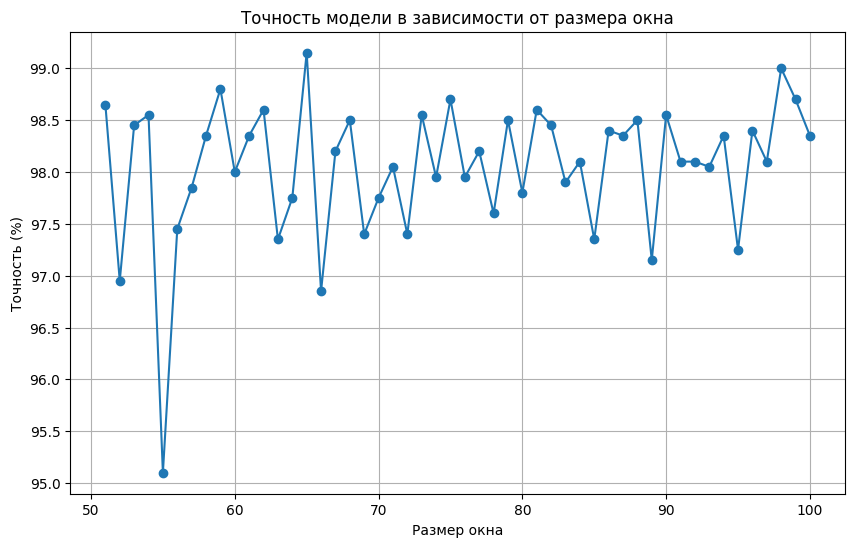

In [181]:
window_sizes = range(51, 101)
accuracies = []

for window in window_sizes:
    X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    
    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_noanomaly[i])), level)
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)
    
    X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_anomaly[i])), level)
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)
    
    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    
    X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))

    print(f"Окно: {window}")
    accuracy = train_nn(model_params, X, y)
    accuracies.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, accuracies, marker='o')
plt.title("Точность модели в зависимости от размера окна")
plt.xlabel("Размер окна")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

Графики показывают, что метод усреднения сигнатур по окнам позволяет лучше отличать процесс с аномалией и без

Поиск окна, где модель теряет способность отличать аномалии

Окно: 200
Epoch [1/20], Loss: 0.1564, Accuracy: 95.10%
Epoch [2/20], Loss: 0.0164, Accuracy: 95.35%
Epoch [3/20], Loss: 0.0087, Accuracy: 97.05%
Epoch [4/20], Loss: 0.1148, Accuracy: 97.85%
Epoch [5/20], Loss: 0.0125, Accuracy: 97.80%
Epoch [6/20], Loss: 0.1780, Accuracy: 97.40%
Epoch [7/20], Loss: 0.0753, Accuracy: 96.55%
Epoch [8/20], Loss: 0.2905, Accuracy: 97.35%
Epoch [9/20], Loss: 0.1207, Accuracy: 98.25%
Epoch [10/20], Loss: 0.1368, Accuracy: 97.90%
Epoch [11/20], Loss: 0.1371, Accuracy: 97.75%
Epoch [12/20], Loss: 0.0057, Accuracy: 97.75%
Epoch [13/20], Loss: 0.0185, Accuracy: 98.20%
Epoch [14/20], Loss: 0.2678, Accuracy: 98.20%
Epoch [15/20], Loss: 0.3524, Accuracy: 97.65%
Epoch [16/20], Loss: 0.0047, Accuracy: 98.05%
Epoch [17/20], Loss: 0.0035, Accuracy: 98.45%
Epoch [18/20], Loss: 0.0087, Accuracy: 98.65%
Epoch [19/20], Loss: 0.0673, Accuracy: 98.30%
Epoch [20/20], Loss: 0.0115, Accuracy: 98.50%
Лучшая точность: 98.45% на эпохе 17
Окно: 210
Epoch [1/20], Loss: 0.1299, Accur

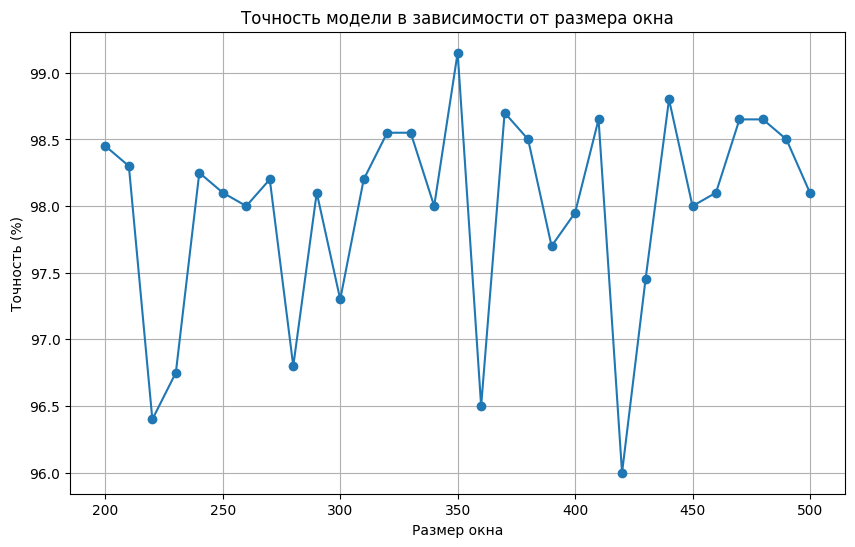

In [14]:
val_of_bad = 0
window = 200
window_sizes = list()
accuracies = []
while val_of_bad < 11:
    X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    
    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_noanomaly[i])), level)
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)
    
    X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_anomaly[i])), level)
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)
    
    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    
    X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))

    print(f"Окно: {window}")
    accuracy = train_nn(model_params, X, y)
    accuracies.append(accuracy)
    window_sizes.append(window)
    window += 10
    if (accuracy - 50.0) < 1e-3  or -1e-3 < (accuracy - 70.0) < 1e-3:
        val_of_bad += 1
    if window > n_steps / 2:
        val_of_bad += 100
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(range(200, 200 + len(accuracies) * 10, 10), accuracies, marker='o')
plt.title("Точность модели в зависимости от размера окна")
plt.xlabel("Размер окна")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

Окно: 500
Epoch [1/20], Loss: 0.1090, Accuracy: 95.80%
Epoch [2/20], Loss: 0.1438, Accuracy: 98.05%
Epoch [3/20], Loss: 0.0241, Accuracy: 96.80%
Epoch [4/20], Loss: 0.2422, Accuracy: 96.60%
Epoch [5/20], Loss: 0.1268, Accuracy: 98.15%
Epoch [6/20], Loss: 0.0589, Accuracy: 98.20%
Epoch [7/20], Loss: 0.0963, Accuracy: 98.10%
Epoch [8/20], Loss: 0.0792, Accuracy: 95.30%
Epoch [9/20], Loss: 0.0344, Accuracy: 98.15%
Epoch [10/20], Loss: 0.0762, Accuracy: 98.10%
Epoch [11/20], Loss: 0.0030, Accuracy: 98.10%
Epoch [12/20], Loss: 0.0055, Accuracy: 98.80%
Epoch [13/20], Loss: 0.0679, Accuracy: 97.65%
Epoch [14/20], Loss: 0.0315, Accuracy: 98.30%
Epoch [15/20], Loss: 0.0161, Accuracy: 98.55%
Epoch [16/20], Loss: 0.0601, Accuracy: 98.35%
Epoch [17/20], Loss: 0.0852, Accuracy: 98.90%
Epoch [18/20], Loss: 0.0227, Accuracy: 98.85%
Epoch [19/20], Loss: 0.1575, Accuracy: 98.45%
Epoch [20/20], Loss: 0.0015, Accuracy: 98.10%
Лучшая точность: 98.10% на эпохе 20
Окно: 600
Epoch [1/20], Loss: 0.1112, Accur

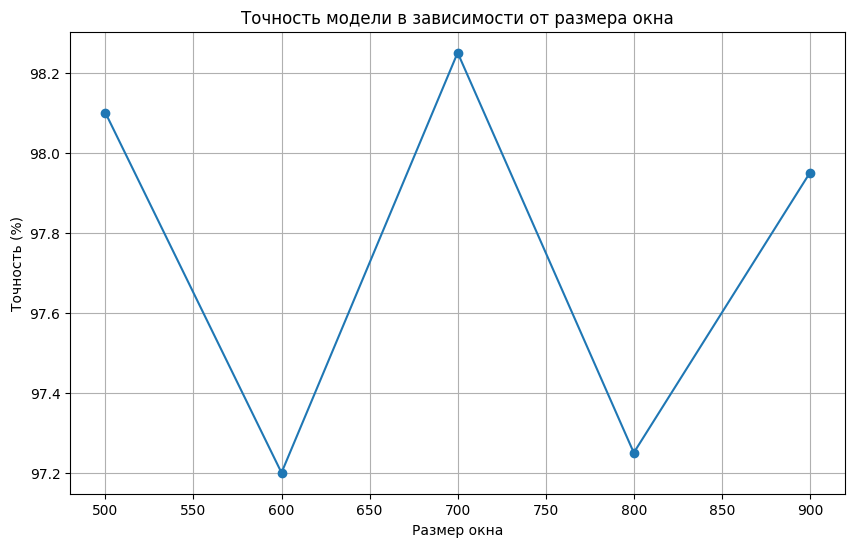

In [16]:
window_sizes = range(int(n_steps/2), n_steps + 1, 100)
accuracies = []

for window in window_sizes:
    X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)
    
    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_noanomaly[i])), level)
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)
    
    X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=anomaly_level)
    
    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_anomaly[i])), level)
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)
    
    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    
    X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))

    print(f"Окно: {window}")
    accuracy = train_nn(model_params, X, y)
    accuracies.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, accuracies, marker='o')
plt.title("Точность модели в зависимости от размера окна")
plt.xlabel("Размер окна")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

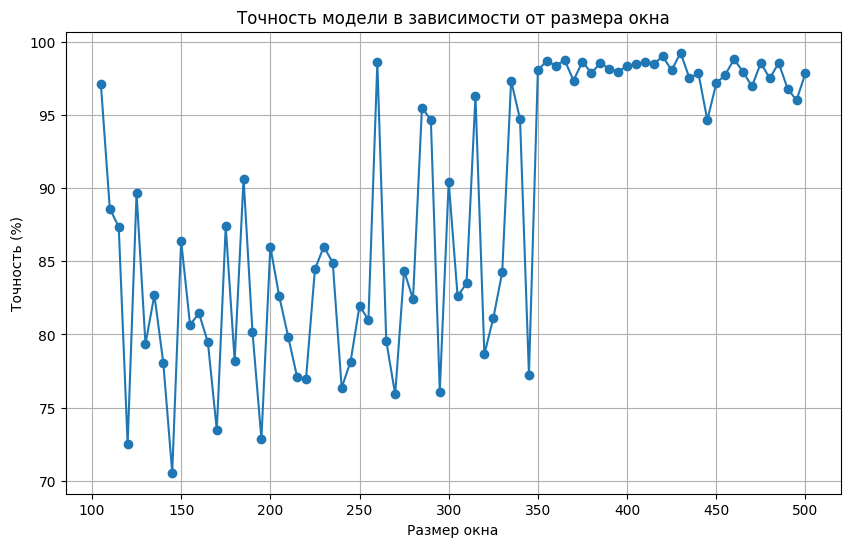

In [92]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, accuracies[:len(window_sizes)], marker='o')
plt.title("Точность модели в зависимости от размера окна")
plt.xlabel("Размер окна")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

Рассмотрим линейный стационарный процесс

In [82]:
model_params = {
    "n_samples": 10000,
    "n_steps": 1000,
    "num_epochs": 20,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}
n_samples = model_params["n_samples"]
n_steps = model_params["n_steps"]
num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]
mu = model_params["mu"]
theta = model_params["theta"]
sigma = model_params["sigma"]
anomaly_level = model_params["anomaly_level"]
dimension = model_params["dimension"]
level = model_params["level"]

Окно: 2
Epoch [1/20], Loss: 0.5684, Accuracy: 70.00%
Epoch [2/20], Loss: 0.4839, Accuracy: 70.00%
Epoch [3/20], Loss: 0.6224, Accuracy: 70.00%
Epoch [4/20], Loss: 0.4713, Accuracy: 70.00%
Epoch [5/20], Loss: 0.6227, Accuracy: 70.00%
Epoch [6/20], Loss: 0.6216, Accuracy: 70.00%
Epoch [7/20], Loss: 0.5953, Accuracy: 70.00%
Epoch [8/20], Loss: 0.4743, Accuracy: 70.00%
Epoch [9/20], Loss: 0.5683, Accuracy: 70.00%
Epoch [10/20], Loss: 0.6746, Accuracy: 70.00%
Epoch [11/20], Loss: 0.5681, Accuracy: 70.00%
Epoch [12/20], Loss: 0.6732, Accuracy: 70.00%
Epoch [13/20], Loss: 0.6724, Accuracy: 70.00%
Epoch [14/20], Loss: 0.5667, Accuracy: 70.00%
Epoch [15/20], Loss: 0.6212, Accuracy: 70.00%
Epoch [16/20], Loss: 0.5682, Accuracy: 70.00%
Epoch [17/20], Loss: 0.5953, Accuracy: 70.00%
Epoch [18/20], Loss: 0.5951, Accuracy: 70.00%
Epoch [19/20], Loss: 0.6818, Accuracy: 70.00%
Epoch [20/20], Loss: 0.5714, Accuracy: 70.00%
Лучшая точность: 70.00% на эпохе 4
Окно: 3
Epoch [1/20], Loss: 0.5150, Accuracy: 

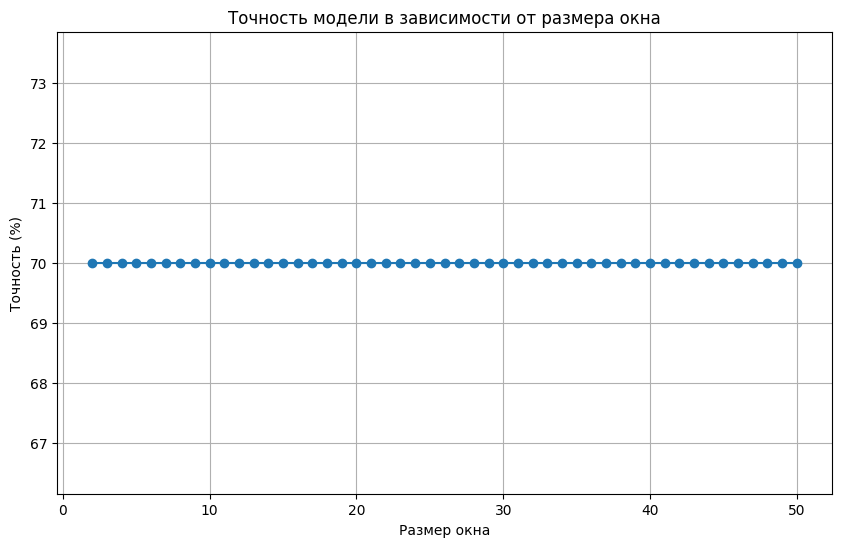

In [83]:
window_sizes = range(2, 51, 1)
accuracies = []

for window in window_sizes:
    X_noanomaly, _ = generate_linear_func(int(n_samples * 0.7), n_steps)
    X_anomaly, _ = generate_linear_func(int(n_samples * 0.3), n_steps, anomaly=True)
    
    y_noanomaly = np.zeros(X_noanomaly.shape[0])
    y_anomaly = np.ones(X_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))
    
    print(f"Окно: {window}")
    accuracy = train_nnmodel_params, X, y)
    accuracies.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, accuracies, marker='o')
plt.title("Точность модели")
plt.xlabel("Номер теста")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

Окно: 2
Epoch [1/20], Loss: 0.5712, Accuracy: 70.35%
Epoch [2/20], Loss: 0.5922, Accuracy: 70.50%
Epoch [3/20], Loss: 0.5702, Accuracy: 70.50%
Epoch [4/20], Loss: 0.6474, Accuracy: 70.50%
Epoch [5/20], Loss: 0.6316, Accuracy: 68.25%
Epoch [6/20], Loss: 0.6074, Accuracy: 70.60%
Epoch [7/20], Loss: 0.5153, Accuracy: 73.00%
Epoch [8/20], Loss: 0.5068, Accuracy: 72.45%
Epoch [9/20], Loss: 0.5862, Accuracy: 80.00%
Epoch [10/20], Loss: 0.5345, Accuracy: 80.20%
Epoch [11/20], Loss: 0.5125, Accuracy: 82.55%
Epoch [12/20], Loss: 0.4443, Accuracy: 86.90%
Epoch [13/20], Loss: 0.2286, Accuracy: 92.85%
Epoch [14/20], Loss: 0.0938, Accuracy: 96.60%
Epoch [15/20], Loss: 0.1099, Accuracy: 96.60%
Epoch [16/20], Loss: 0.0434, Accuracy: 97.10%
Epoch [17/20], Loss: 0.0362, Accuracy: 97.10%
Epoch [18/20], Loss: 0.0399, Accuracy: 97.45%
Epoch [19/20], Loss: 0.0422, Accuracy: 97.65%
Epoch [20/20], Loss: 0.0766, Accuracy: 98.05%
Лучшая точность: 97.10% на эпохе 17
Окно: 3
Epoch [1/20], Loss: 0.7446, Accuracy:

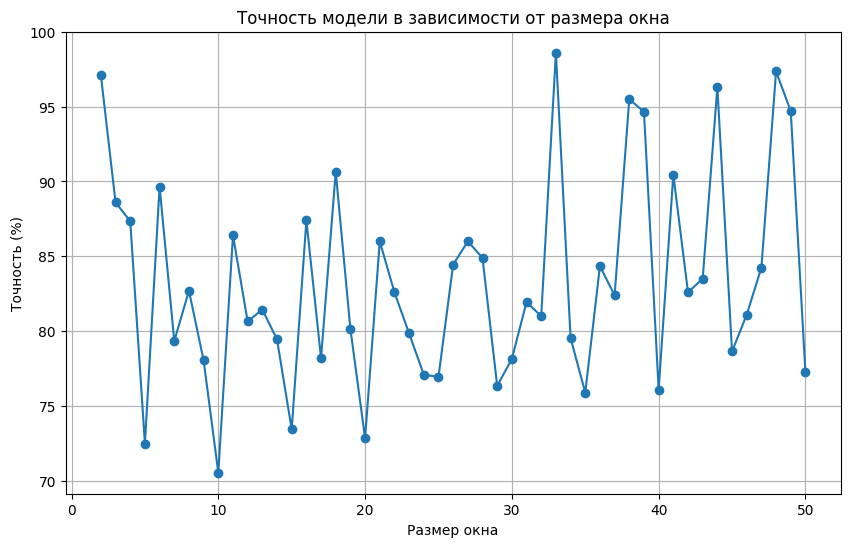

In [89]:
window_sizes = range(2, 51, 1)
accuracies = []
import copy
for window in window_sizes:
    X_noanomaly, timeline = generate_linear_func(int(n_samples * 0.7), n_steps)
    X_anomaly, timeline = generate_linear_func(int(n_samples * 0.3), n_steps, anomaly=True)

    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = calc_sig_window(window, X_noanomaly[i], normalize_arr(timeline))
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)

    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = calc_sig_window(window, X_anomaly[i], normalize_arr(timeline))
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)

    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))
    print(f"Окно: {window}")
    accuracy = train_nn(model_params, X, y)
    accuracies.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, accuracies, marker='o')
plt.title("Точность модели в зависимости от размера окна")
plt.xlabel("Размер окна")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()